In [119]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy import Matrix, symbols, eye, zeros, solve, Eq, re, Symbol, atan, pi, exp, sin, cos, sqrt, lambdify, pprint
from numpy import array, arange, argmax, rad2deg, angle
import scienceplots


plt.style.use([
    'science',
    'notebook',
    'grid',
    'retro'
])

In [120]:
mass = 4 # kg

k1 = 4 # N/m
k2 = 9 # N/m
k3 = 1 # N/m

c1 = 2.4 # Ns/m
c2 = .2 # Ns/m
c3 = .1 # Ns/m

M = Matrix([
    [mass, 0, 0],
    [0, 2*mass, 0],
    [0, 0, .5*mass]
])

K = Matrix([
    [k1+k2, -k2, 0],
    [-k2, k2+k3, -k3],
    [0, -k3, k3]
])

C = Matrix([
    [c1+c2, -c2, 0],
    [-c2, c2+c3, -c3],
    [0, -c3, c3]
])

X0 = array([
    [1.0],
    [.0],
    [.0]
])

V0 = array([
    [.15],
    [.23],
    [.37]
])

N = M.shape[0]

In [121]:
# Calculando M á menos meio
M_minus_half = zeros(N, N)
M_half = zeros(N, N)


for i in range(N):
    M_minus_half[i, i] = (1/sqrt(M[i, i])).evalf()
    M_half[i, i] = (sqrt(M[i, i])).evalf()


# Calculando Ktil
K_til = M_minus_half @ K @ M_minus_half

# Calculando Ctil
C_til = M_minus_half @ C @ M_minus_half

# Encontrando as frequências naturais e amortecidas
lmbd = symbols('lambda')

expr_wn = (K_til - lmbd*eye(N))

eig_wn = solve(expr_wn.det(), lmbd)
wn = [re(sqrt(eig_wn[i])) for i in range(N)]

In [122]:
# Encontrando os auto-vetores normalizados no unitário
norm_syms = [Symbol(f'norm_{i}') for i in range(N)]

X = Matrix(norm_syms)

norm_eq = Eq(
    (X.T@X)[0],
    1
)

P = np.zeros((N, N))
for i in range(N):
    sys_wn = expr_wn.subs(lmbd, eig_wn[i])
    sys = sys_wn @ X

    sol = solve(
        [sys[j] for j in range(N-1)] + [norm_eq],
        norm_syms,
        dict=True
    )[0]

    v = array([
        sol[norm_syms[j]] for j in range(N)
    ])

    P[:, i] = v

# Matriz P

diag_  = P.T @ C_til @ P
zetas  = [diag_[i, i] / (2*wn[i]) for i in range(N)]

wds    = [wn[i] * sqrt(1 - zetas[i]**2) for i in range(N)]

# matrix spectral de P
S = M_minus_half @ P
S_inv = S.inv()

In [123]:
wn

[0.453795557844648, 0.812938700695640, 2.03302736346360]

In [124]:
wds

[0.451751728220856, 0.810885915265293, 2.01528645447158]

In [125]:
P

array([[-0.36995029, -0.31552957, -0.87382943],
       [-0.70783238, -0.51348352,  0.48508555],
       [-0.60175585,  0.79798231, -0.03337867]])

In [126]:
pprint(S)

⎡-0.184975144881894  -0.157764783647186  -0.436914715724566 ⎤
⎢                                                           ⎥
⎢-0.250256539445183  -0.181543839917815   0.171503640348581 ⎥
⎢                                                           ⎥
⎣-0.425505639694153  0.564258702044632   -0.0236022828426092⎦


In [127]:
# condições iniciais inversas modais
r_0 = S_inv @ X0
r_dot_0 = S_inv @ V0

pprint(r_0)
print(' ')
pprint(r_dot_0)

⎡-0.739900579527567⎤
⎢                  ⎥
⎢-0.631059134588773⎥
⎢                  ⎥
⎣-1.74765886289826 ⎦
 
⎡-0.886331292881947 ⎤
⎢                   ⎥
⎢-0.0111480961240722⎥
⎢                   ⎥
⎣0.0359521795031264 ⎦


In [128]:
# Calculando as soluções modais desacopladas
t = symbols('t')

r = []

forced_response_forces = Matrix([
    [.0],
    [.1],
    [.0]
])

B = Matrix([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

F = P.T @ M_minus_half @ B @ forced_response_forces
wf = 1

for i in range(N):
    w = wn[i]
    wd = wds[i]
    zeta = zetas[i]
    
    r_zero = r_0[i]
    rdot_zero = r_dot_0[i]

    Ai = sqrt(
        ((r_zero * wd)**2 + (rdot_zero + zeta*w*r_zero)**2) / wd**2
    )

    phi_i = atan(
        (r_zero*wd) / (rdot_zero + zeta*w*r_zero)
    )

    if rdot_zero == 0:
        phi_i = pi/2
    
    expr_r = Ai*exp(-zeta*w*t)*sin(wd*t + phi_i)

    f0 = F[i]
    A0 = f0 / sqrt( (w**2 - wf**2)**2 + (2*zeta*w*wf)**2 )
    theta = atan( (2*zeta*w*wf) / (w**2 - wf**2) )
    
    if (w**2 - wf**2) == 0:
        theta = pi/2

    expr_r += A0*cos(wf*t - theta)
    
    r.append(
        expr_r
    )

R = Matrix(r)
pprint(F)

⎡-0.0250256539445183⎤
⎢                   ⎥
⎢-0.0181543839917815⎥
⎢                   ⎥
⎣0.0171503640348581 ⎦


In [129]:
# Retornando ao dominio fisico
x_t = S @ Matrix(r)
x_t.evalf()

x_t

Matrix([
[-0.00235731961164089*cos(t - 0.169427241818086) + 0.00579569613928651*cos(t + 0.107933999123303) + 0.00799475907533179*cos(t + 0.328177600923862) - 0.769311116729152*exp(-0.267993968243903*t)*sin(2.01528645447158*t + 1.44863487308111) - 0.099988393682361*exp(-0.0577352882826866*t)*sin(0.810885915265293*t + 1.4780770134998) - 0.400089820037949*exp(-0.0430207434734097*t)*sin(0.451751728220856*t + 0.349130855980761)],
[ 0.00092532679791079*cos(t - 0.169427241818086) + 0.00784111216898752*cos(t + 0.107933999123303) + 0.00919976707222149*cos(t + 0.328177600923862) + 0.301980346120586*exp(-0.267993968243903*t)*sin(2.01528645447158*t + 1.44863487308111) - 0.115059118496967*exp(-0.0577352882826866*t)*sin(0.810885915265293*t + 1.4780770134998) - 0.541289446719302*exp(-0.0430207434734097*t)*sin(0.451751728220856*t + 0.349130855980761)],
[  -0.000127343214183366*cos(t - 0.169427241818086) + 0.013332068991186*cos(t + 0.107933999123303) - 0.0285939122452992*cos(t + 0.328177600923862) - 0.

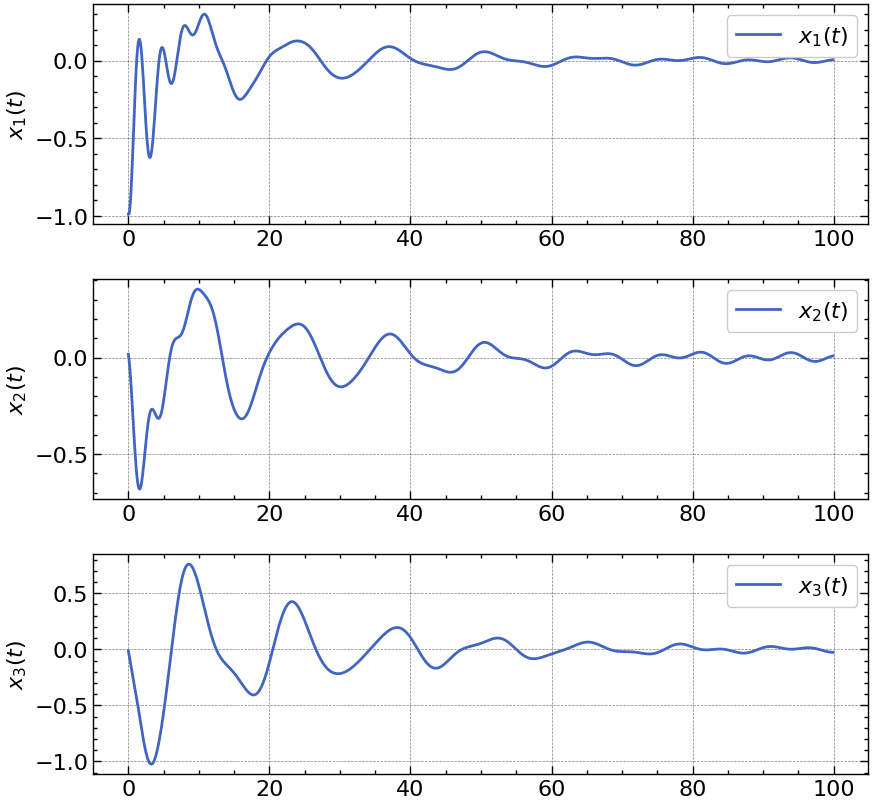

In [130]:
# Simulação

sampling_period = 1e-1
samples = 10000

time = arange(0, samples*sampling_period, sampling_period)

x = [lambdify(t, x_t[i]) for i in range(N)]

xi = [x[i](time) for i in range(N)]

fig, ax = plt.subplots(N, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.25)

idx = int(100 / .1)

for i in range(N):
    ax[i].plot(time[:idx], xi[i][:idx], label=f'$x_{i+1}(t)$')
    ax[i].set_ylabel(f'$x_{i+1}(t)$')
    ax[i].legend()

plt.savefig('imagens/forced_response.png', dpi=300)

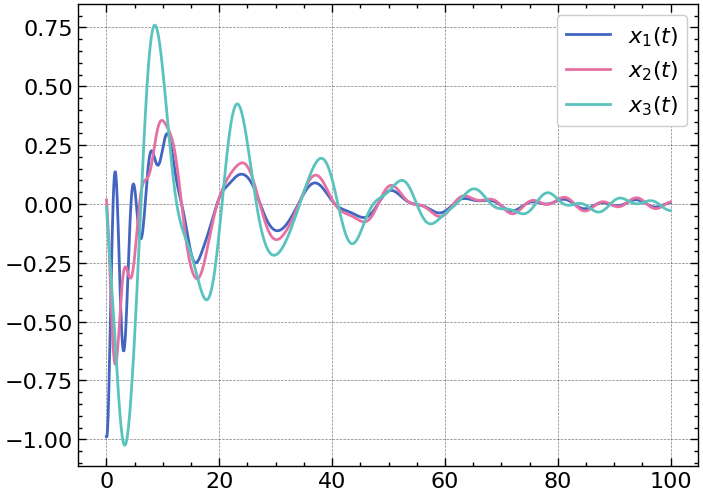

In [131]:
plt.figure()

for i in range(N):
    plt.plot(time[:idx], xi[i][:idx], label=f'$x_{i+1}(t)$')

plt.legend()

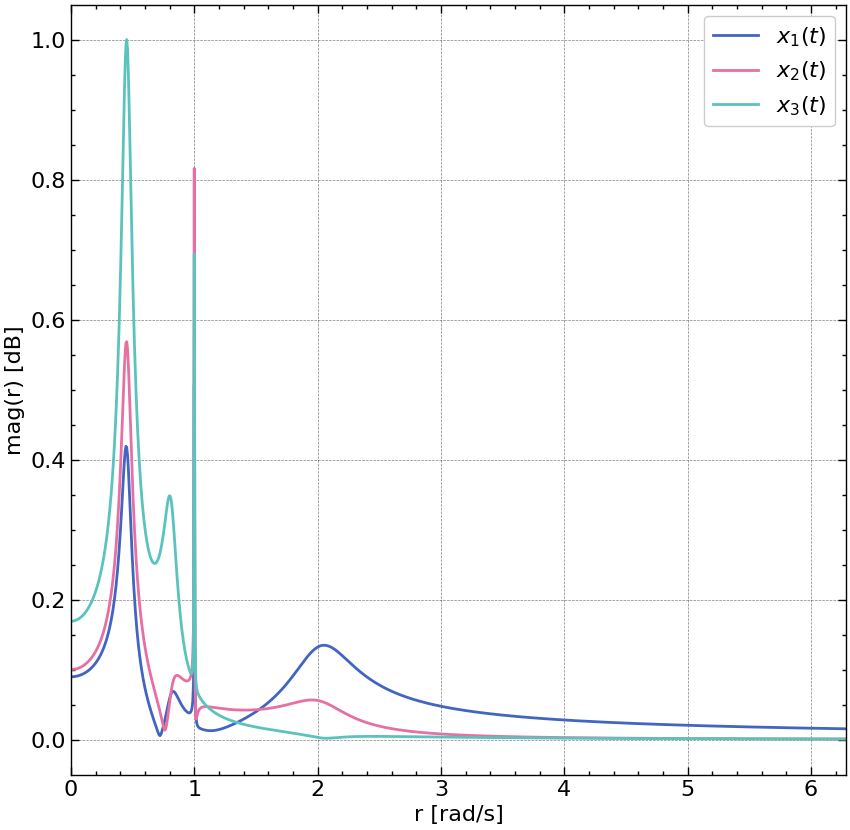

In [132]:
def fft(signal, sampling_time):
    fft = np.fft.fft(signal)
    N = signal.shape[0]

    f = np.fft.fftfreq(len(signal), sampling_time)

    K = N // 2

    freqs = f[:K]*2*np.pi
    amplitudes = np.abs(fft)[:K] * (1 / N)

    phase = np.rad2deg(np.angle(fft)[:K])

    return freqs, amplitudes, phase


ffts   = [fft(xi[i], sampling_period) for i in range(N)]

maximum_amp = np.max([
    np.max(ffts[i][1]) for i in range(N)
])

maximum_freq = np.max(
    [ffts[i][0][np.argmax(ffts[i][1])] for i in range(N)]
)

plt.figure(figsize=(10, 10))

for i in range(N):
    plt.plot(
        ffts[i][0]/maximum_freq,
        ffts[i][1]/maximum_amp,
        label=f'$x_{i+1}(t)$'
    )

plt.xlim(0, 2*np.pi)
plt.xlabel('r [rad/s]')
plt.ylabel('mag(r) [dB]')
plt.legend()